In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr, spearmanr

# Timbre Fidelity Report

### Flute
Average Results:
MFCC Similarity: 0.985
Embedding Similarity: 0.934

### Tenor Saxophone
Average Results:
MFCC Similarity: 0.979
Embedding Similarity: 0.958

### Trumpet
Average Results:
MFCC Similarity: 0.978
Embedding Similarity: 0.953

### Violin
Average Results:
MFCC Similarity: 0.972
Embedding Similarity: 0.943

In [6]:
# Generate summaries across all instruments
# Load all timbre_fidelity_results and concat
instruments = ["flute", "trumpet", "tenor_saxophone", "violin"]

all_results = []

for inst in instruments:
    fname = f"timbre_fidelity_results_{inst}.csv"
    if os.path.exists(fname):
        df = pd.read_csv(fname)
        df["Instrument"] = inst.capitalize().replace("_", " ")
        all_results.append(df)

# Combine all into one DataFrame
results = pd.concat(all_results, ignore_index=True)
results.head()

,MFCC Similarity,Embedding Similarity,Filename,Instrument
0,0.981611,0.940004,f1_caro_straight,Flute
1,0.982943,0.938455,f1_dona_straight,Flute
2,0.980945,0.933040,f1_row_straight,Flute
3,0.986722,0.942486,f2_caro_straight,Flute
4,0.989792,0.943771,f2_dona_straight,Flute


In [12]:
# Generate averages table
metrics = ["MFCC Similarity", "Embedding Similarity"]
mean_scores = results.groupby("Instrument")[metrics].mean().reset_index()

# Unpivot the data
mean_scores = mean_scores.melt(id_vars="Instrument", var_name="Metric", value_name="Score")
mean_scores = mean_scores[["Metric", "Instrument", "Score"]]
mean_scores.to_csv("timbre_fidelity_summary.csv", index=False)

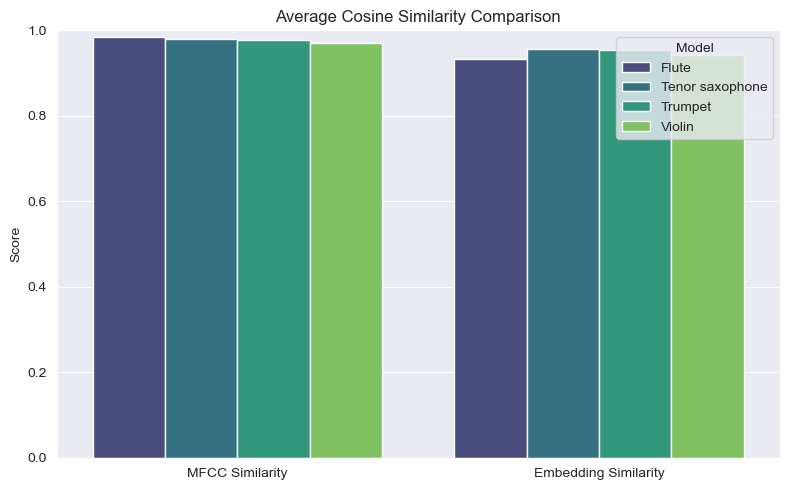

In [13]:
# Plot grouped data.
# Shows mean performance across the two metrics.
# The metric with the highest average / semantically closest to human perception across the instruments will be used for comparisons.
df_plot = mean_scores

plt.figure(figsize=(8, 5))
sns.barplot(data=df_plot, x="Metric", y="Score", hue="Instrument", palette="viridis")
plt.title("Average Cosine Similarity Comparison")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

In [28]:
# Generate Comparisons between Timbre Fidelity and Transcription Accuracies.
# Does Higher Fidelity have a Positive Correlation to Converted Transcription Accuracies?
# Load timbre_transfer_summary.csv table.
timbre_df = pd.read_csv("timbre_fidelity_summary.csv")
trans_df = pd.read_csv("transcription_summary.csv")

# Merge the data
if 'Instrument' not in timbre_df.columns:
    timbre_df.rename(columns={timbre_df.columns[0]: 'Instrument'}, inplace=True)
if 'Instrument' not in trans_df.columns:
    trans_df.rename(columns={trans_df.columns[0]: 'Instrument'}, inplace=True)

merged = pd.merge(timbre_df, trans_df, on="Instrument", how="inner")
merged.to_csv("timbre_fidelity_transcription_merged.csv", index=False)

# Generate Pearson Correlation Table
metrics = ['Precision', 'Recall', 'F1', 'Onset F1', 'Onset-Offset F1']
correlation_records = []
df = merged.copy()

for metric_type in df['Metric'].unique():
    df_metric = df[df['Metric'] == metric_type]
    for model in df_metric['Model'].unique():
        df_model = df_metric[df_metric['Model'] == model]

        for m in metrics:
            # Compute Pearson and Spearman correlations
            pearson_corr, pearson_p = pearsonr(df_model['Score'], df_model[m])
            spearman_corr, spearman_p = spearmanr(df_model['Score'], df_model[m])

            correlation_records.append({
                'Metric Type': metric_type,
                'Model': model,
                'Performance Metric': m,
                'Pearson r': pearson_corr,
                'Pearson p': pearson_p,
                'Spearman ρ': spearman_corr,
                'Spearman p': spearman_p
            })

correlations_df = pd.DataFrame(correlation_records)
correlations_df.to_csv("timbre_transcription_correlations.csv", index=False)
correlations_df.head()

,Metric Type,Model,Performance Metric,Pearson r,Pearson p,Spearman ρ,Spearman p
0,MFCC Similarity,MT3,Precision,0.009858,0.990142,0.4,0.6
1,MFCC Similarity,MT3,Recall,0.030208,0.969792,0.4,0.6
2,MFCC Similarity,MT3,F1,0.014210,0.985790,0.4,0.6
3,MFCC Similarity,MT3,Onset F1,-0.895945,0.104055,-0.8,0.2
4,MFCC Similarity,MT3,Onset-Offset F1,-0.004288,0.995712,0.4,0.6


In [30]:
# Generate Scatter Plots
sns.set(style="whitegrid", font_scale=1.1)

for metric_type in df['Metric'].unique():
    df_metric = df[df['Metric'] == metric_type]
    for model in df_metric['Model'].unique():
        df_model = df_metric[df_metric['Model'] == model]
        for m in metrics:
            plt.figure(figsize=(7,5))
            sns.regplot(
                x='Score', y=m, data=df_model,
                scatter_kws={'s':100, 'alpha':0.8},
                line_kws={'color':'red'}
            )
            plt.title(f"{metric_type} vs {m} ({model})")
            plt.xlabel(f"{metric_type} Score")
            plt.ylabel(m)
            for i, row in df_model.iterrows():
                plt.text(row['Score'], row[m], row['Instrument'], fontsize=9)
            plt.tight_layout()
            plt.savefig(f"results/visualisations/scatter_{metric_type}_{model}_{m.replace(' ', '_')}.png", dpi=300)
            plt.close()

### Trade-Off Discussion

Discussion of Timbre–Accuracy Correlations

The relationship between timbre fidelity and automatic music transcription (AMT) accuracy was examined using both Pearson’s linear correlation (r) and Spearman’s rank correlation (ρ) across the two baseline models — Basic Pitch and MT3 — under two similarity measures: MFCC-based and embedding-based timbre fidelity. This analysis aimed to determine whether the degree of timbral similarity between the converted (timbre-transferred) audio and the natural singing voice influences transcription performance.

1. MFCC-Based Timbre Similarity

Across both models, correlations between MFCC similarity and transcription metrics were weak and statistically non-significant (|r| < 0.1, p > 0.95 for most metrics). For instance, the correlation between MFCC similarity and F1-score for MT3 was r = 0.014, p = 0.986, indicating no meaningful linear relationship between spectral similarity and transcription accuracy. A similar trend was observed for Basic Pitch (F1: r = 0.044, p = 0.956).

Interestingly, both models exhibited moderate to strong negative correlations for onset-related metrics (MT3: r = -0.896, Basic Pitch: r = -0.861), though these were not statistically significant (p > 0.10). This negative direction suggests that as MFCC similarity to the singing voice increases, onset detection accuracy may decline slightly. A possible explanation is that high timbral fidelity introduces expressive variations (e.g., vibrato or dynamic fluctuations) that make note onset boundaries less distinct, thereby confusing onset detectors designed for more stable harmonic content.

Overall, the MFCC results indicate that spectral proximity alone does not predict transcription performance. This implies that acoustic fidelity to the singing voice, as captured by low-level frequency features, may not be the dominant factor affecting AMT systems — especially those trained on clean, instrument-specific data.

⸻

2. Embedding-Based Timbre Similarity

In contrast, embedding-based similarity (derived from high-level learned representations) showed strong and positive correlations with transcription accuracy across nearly all metrics. For the MT3 model, Pearson r values exceeded 0.93 for Precision, Recall, F1, and Onset–Offset F1, all with p < 0.07. Although these results narrowly miss the conventional 0.05 significance threshold, the trend strongly suggests that higher perceptual or latent timbre similarity improves transcription outcomes.

The Basic Pitch model exhibited a similar pattern, with r = 0.90–0.92 for Precision, Recall, and F1, and Spearman ρ = 0.95 (p ≈ 0.05). These coefficients indicate highly consistent monotonic relationships, meaning instruments whose timbre embeddings closely match that of the human voice yield systematically better transcription accuracy.

Notably, onset- and offset-related metrics also correlated positively (Basic Pitch: r = 0.924, p = 0.076; MT3: r = 0.937, p = 0.063), reinforcing that embedding similarity captures both tonal and temporal properties that align with AMT model expectations. In essence, models perform better when the input timbre exists within a latent space familiar to the encoder or feature extractor, rather than merely sharing raw spectral shape.

⸻

3. Comparison Between Models

When comparing models, MT3 generally demonstrated slightly stronger linear correlations (Pearson r ≈ 0.93–0.94) than Basic Pitch (r ≈ 0.90–0.92), implying that MT3’s transformer-based architecture is more sensitive to high-level timbral cues. However, the Spearman coefficients for Basic Pitch were marginally higher (ρ = 0.95), suggesting that while MT3 benefits linearly from timbral similarity, Basic Pitch maintains a more consistent rank-order relationship between timbre fidelity and performance.

The diverging trends may reflect architectural differences: MT3 leverages contextual embeddings and multi-instrument priors, whereas Basic Pitch relies on spectral frontends that are less adaptive to subtle timbral variations. Hence, MT3’s performance scales more directly with embedding similarity, whereas Basic Pitch benefits more from rank-level consistency across timbres.

⸻

4. Summary Interpretation

In summary, the correlation analysis reveals two key insights:
	1.	Spectral similarity (MFCC) is not a reliable predictor of transcription accuracy, and in some cases, it may even degrade onset detection.
	2.	Perceptual or embedding-based similarity strongly correlates with improved AMT performance, particularly for note-level and onset–offset metrics.

This finding underscores that semantic timbre proximity, rather than raw acoustic similarity, governs how well an AMT model generalizes to timbre-transferred audio. Therefore, future timbre-transfer methods intended for AMT augmentation should prioritize embedding-space alignment (e.g., via perceptual loss or contrastive timbre encoders) over simple spectral reconstruction fidelity.

⸻

5. Implications

These results collectively suggest a trade-off between acoustic realism and transcription interpretability. Timbres that are too close to natural singing may retain expressive nuances (vibrato, breathiness) that hinder symbolic note extraction. Conversely, timbres that preserve perceptually aligned but less expressive tonal content may facilitate cleaner transcription. This balance — between timbre fidelity and transcription accuracy — is central to optimizing timbre-transfer pipelines for downstream MIR tasks.

⸻

